<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/Ch04_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ch 04. 모델 훈련**
시스템이 실제로 어떻게 작용할까? 이해하면 적절한 모델, 올바른 훈련 알고리즘, 작업에 맞는 좋은 하이퍼 파라미터를 빠르게 찾을 수 있다.

선형 회귀
* 직접 계산하여 모델 파라미터 구하기
* 경사 하강법 (배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법) 사용

그 다음에는 비선형 데이터셋에 훈련시킬 수 있는 다항 회귀. 선형보다 파라미터가 많아서 훈련 데이터에 과대적합되기 쉽다. 따라서 그 다음엔 과대적합을 감소시킬 수 있는 규제를 몇 가지 알아보자. 마지막으로는 로지스틱 회귀와 소프트맥스 회귀를 살펴보자.

##4.1 선형 회귀

일반적으로 선형 모델은 입력 특성의 **가중치 합과 편향(절편)**이라는 상수를 더해 예측을 만든다. 이를 벡터 형태로 쓸 수 있다. 이것이 선형 회귀.

훈련시켜보자. 훈련시킨다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것. 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정해야 한다. 가장 널리 사용되는 성능 측정 지표는 RMSE. 이것을 최소화 해야 한다. 

###4.1.1 정규방정식

세타값을 최소화하기 위한 해석적인 방법. 정규방정식 이용하기.
세타^ = (Xt * X)^-1 * Xt * y

이 공식 테스트하기 위해 선형처럼 보이는 데이터를 생성하자.

In [1]:
import numpy as np

X=2*np.random.rand(100, 1)
y=4+3*X+np.random.randn(100, 1)

이제 정규방정식을 이용해 세타햇을 구해보자. inv()=역행렬 계산, dot()=행렬 곱셈

In [2]:
X_b=np.c_[np.ones((100,1)), X] #모든 샘플에 x0=1 추가
theta_best=np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_best

array([[4.2441624 ],
       [2.92929637]])

이 데이터를 생성하기 위해 사용했던 함수의 세타0=4, 세타1=3 이었다. 비슷하지만 잡음 때문에 정확하게 재현하지 못했다.

세타햇을 사용해 구해보자.

In [4]:
X_new=np.array([[0], [2]])
X_new_b=np.c_[np.ones((2,1)), X_new] #모든 샘플에 x0=1 추가
y_predict=X_new_b.dot(theta_best)
y_predict

array([[ 4.2441624 ],
       [10.10275514]])

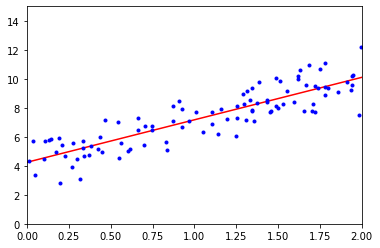

In [5]:
#그림으로 나타내면
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0,2,0,15])
plt.show()

사이킷런에서 선형 회귀를 수행하는 것은 간단

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.2441624]), array([[2.92929637]]))

In [7]:
lin_reg.predict(X_new)

array([[ 4.2441624 ],
       [10.10275514]])

LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 한다.

In [8]:
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.2441624 ],
       [2.92929637]])

이 함수는 세타햇 = X^+ * y를 계산한다. X^+는 X의 유사역행렬.

In [9]:
#유사역행렬 구할 수 있다
np.linalg.pinv(X_b).dot(y)

array([[4.2441624 ],
       [2.92929637]])

유사역행렬 자체는 특잇값 분해(SVD)라고 부르는 표준 행렬 분해 기법을 사용해 계산한다. 정규방정식보다 훨씬 효율적이고, 극단적인 경우도 처리할 수 있으며, 유사역행렬은 역행렬과 달리 항상 구할 수 있다.

###4.1.2 계산 복잡도
정규방정식은 (n+1)(n+1)크기가 되는 Xt*X의 역행렬을 계산한다. 역행렬을 계산하는 계산 복잡도는 특성 수가 두 배로 늘어나면 계산 시간이 대략 2^2.4=5.3에서 2^3=8배 증가한다. = (O(n^2.4)) 에서 O(n^3))

사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2). 또한 학습된 선형 회귀 모델은 예측이 매우 빠르다.

이제 아주 다른 방법으로 선형 회귀 모델을 훈련시켜보자. 이 방법은 특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합.

##4.2 경사 하강법 (GD)
반복해서 파라미터 조정하기. 가장 가파른 길을 따라 아래로 내려가기. 파라미터 벡터 세타에 대해 비용 함수의 현재 그래디언트를 계산해 그래디언트가 감소하는 방향으로 진행한다. 0이 되면 최솟값에 도달한 것.

경사 하강법에서 중요한 파라미터는 스텝의 크기로, 학습률 파라미터로 결정된다. 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간아 오래 걸린다. 하지만 너무 크면 골짜기를 가로질러 반대편으로 건너뛰게 되어 전보다 높은 곳으로 갈 지도 모른다.

다양한 지형이 있으면 최솟값으로 수렴하기가 어렵다. 전역 최솟값이 아닌 지역 최솟값에 수렴하거나, 평탄한 지역을 지나지 못하고 일찍 멈추는 문제. 하지만 선형 회귀를 위한 MSE 비용 함수는 볼록 함수.

비용 함수는 특성들의 스케일이 매우 다르면 길쭉한 모양일 수 있다. 결국 최솟값에 도달하긴 하지만 시간이 오래 걸릴 것. -> 경사 하강법 사용 시 모든 특성이 같은 스케일을 갖도록 StandardScaler 등 이용해주기. 

###4.2.1 배치 경사 하강법
경사 하강법을 구현하려면 각 모델 파라미터 세타j에 대해 비용 함수의 그래디언트를 계산해야 한다. 다시 말해, 세타j가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산해야 한다. = 편도함수.

이 공식은 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산한다. 그래서 이 알고리즘을 배치 경사 하강법이라고 함. 따라서 큰 훈련 세트에서 느리다. 그러나 특성 수에 민감하지 않다.

스텝 알고리즘을 간단히 구현해보자.

In [10]:
eta=0.1 #학습률
n_iterations=100
m=100

theta=np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations):
  gradients=2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta=theta-eta*gradients

In [11]:
theta

array([[4.22998334],
       [2.94064724]])

정규방정식으로 구한 것과 같다. 경사 하강법이 완벽히 작동함.

학습률을 바꿔보면? 너무 낮으면 시간이 오래 걸림. 너무 높으면 알고리즘이 이리저리 널뛰면서 발산함. 적절한 학습률을 찾으려면 반복 횟수를 제한한 그리드 탐색을 사용. 반복 횟수는 일단 크게 지정하고, 그래디언트 벡터가 아주 작아지면 경사 하강법이 거의 최솟값에 도달한 것으로 보고 중지하는 것.

###4.2.2 확률적 경사 하강법
배치 하강법은 훈련 세트가 커지면 느려질 것임. 확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 선택해 그 하나의 샘플에 대한 그래디언트를 계산한다. 훨씬 빠르고 매우 큰 훈련 세트도 훈련시킬 수 있다.

그러나 확률적이기 때문에 배치 경사 하강법보다 불안정. 요동치며 수렴. 좋은 파라미터가 구해지긴 하지만 최적치는 아닐 것. 비용 함수가 불규칙하면 좋긴 함.

무작위성은 지역 최솟값에서는 탈출시켜주지만 전역 최솟값에는 다다르지 못하게 할 수도 있음. 학습률을 점진적으로 감소시키면 해결 가능. 매 반복에서 학습률을 결정하는 함수 학습 스케줄 이용. 

In [12]:
n_epochs=50
t0, t1=5, 50 #학습 스케줄 하이퍼 파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1) #무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index=np.random.randint(m)
    xi=X_b[random_index:random_index+1]
    yi=y[random_index:random_index+1]
    gradients=2*xi.T.dot(xi.dot(theta)-yi)
    eta=learning_schedule(epoch*m+i)
    theta=theta-eta*gradients

In [13]:
theta

array([[4.21909516],
       [2.9177202 ]])

일반적으로 한 반복에서 m번 되풀이, 이 각 반복을 에포크라고 함. 배치 경사 하강법이 전체 훈련 세트에 대해 1000번 반복하는 동안 이 코드는 50번만 반복하고도 매우 좋은 값에 도달함.

샘플을 무작위로 선택하므로 어떤 샘플은 여러 번 선택될 수도 있고 어떤 샘플은 선택되지 못할 수도 있다. 알고리즘이 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후 차례대로 하나씩 선택한 후 다음 에포크에서 다시 섞는 방법을 사용할 수 있다. 조금 더 시간이 걸림.

사이킷런에서 SGD 방식으로 선형 회귀를 사용해보자. 규제는 없이 돌려보자.

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.20544219]), array([2.91082737]))

###4.2.3 미니배치 경사 하강법
각 스텝에서 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그래디언트를 계산한다. 미니배치를 어느 정도 크게 하면 SGD보다 덜 불규칙하게 움직일 수 있다. 하지만 지역 최솟값에서 빠져나오기는 더 힘들지도 모른다.

##4.3 다항 회귀
데이터가 단순 직선보다 복잡한 형태라면? 신기하게도 비선형 데이터를 학습하는 데 선형 모델을 사용할 수 있다. 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것. = 다항 회귀

간단한 2차 방정식으로 비선형 데이터를 생성해보자.

In [16]:
m=100
X=6*np.random.rand(m, 1)-3
y=0.5*X**2+X+2+np.random.randn(m,1)

직선은 잘 맞지 않을테니 훈련 데이터를 변환시켜보자. 훈련 세트의 각 특성을 제곱하여 새로운 특성으로 추가.

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X)
X[0]

array([1.88662551])

In [18]:
X_poly[0]

array([1.88662551, 3.55935583])

In [19]:
#이 확장된 훈련 데이터에 linear regression 적용
lin_reg=LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.11443555]), array([[1.03044901, 0.48324787]]))

원래 함수가 y=0.5x1^2 + 1.0x1 + 2.0 + 잡음 이므로 예측이 나쁘지 않음.

특성이 여러개일 경우 다항 회귀는 이 특성 사이의 관계를 찾을 수 있다.

##4.4 학습 곡선
고차 다항 회귀를 적용하면 선형 회귀보다 훨씬 훈련 데이터에 잘 맞추려 할 것. 얼마나 복잡한 모델을 사용할 지 어떻게 결정할까? 어떻게 모델이 데이터에 과대적합 또는 과소적합 되었는지 알 수 있을까?

전에는 모델의 일반화 성능을 추정하기 위해 교차 검증을 사용했다. 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘다면 모델이 과대적합된 것. -> 모델이 복잡하다.

다른 방법은 학습 곡선을 살펴보는 것. 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타낸다. 이 그래프를 생성하기 위해서는 단순히 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 된다.

In [20]:
#방법을 정의해보자
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
  train_errors, val_errors=[], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict=model.predict(X_train[:m])
    y_val_predict=model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='훈련 세트')
  plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='검증 세트')

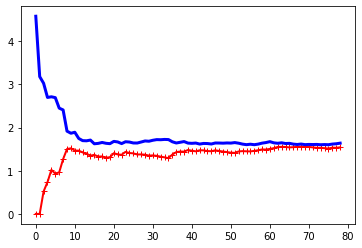

In [21]:
#단순 선형 회귀 모델의 학습 곡선
lin_reg=LinearRegression()
plot_learning_curves(lin_reg, X, y)

과소적합 되었다. 조금 설명이 필요하다. 그래프가 0에서 시작하므로 훈련 세트에 하나 혹은 두개의 샘플이 있을 땐 모델이 완벽하게 작동하지만, 훈련 세트에 샘플이 추가되면 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해진다. 그래서 곡선이 어느정도 평평해질 때까지 오차가 계속 상승한다. 검증 데이터에 대한 모델의 성능을 보면 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화할 수 없어서 검증 오차가 초기에 매우 크다. 모델에 훈련 샘플이 추가되면서 검증 오차가 서서히 감소한다. 하지만 선현 회귀의 직선은 데이터를 잘 모델링 할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워진다.

과소적합 모델의 전형적인 모습. **두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 가까이 근접**해 있다.

같은 데이터에서 10차 다항 회귀 모델의 학습 곡선을 그려보자.

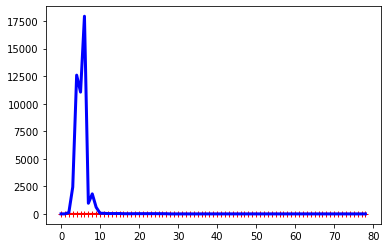

In [22]:
from sklearn.pipeline import Pipeline

polynomial_regression=Pipeline([('poly_features', PolynomialFeatures(degree=10, include_bias=False)), ('lin_reg', LinearRegression())])
plot_learning_curves(polynomial_regression, X, y)

두 그래프의 차이점
* 보통 고차원 모델의 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮다
* 두 곡선 사이의 공간. 훈련 데이터에서의 모델 성능이 검증 데이터보다 낫다는 뜻이고, 과대적합 모델의 특징이다.

##4.5 규제가 있는 선형 모델
과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것. 자유도를 줄이면 데이터에 과대적합되기 더 어려워진다. 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것.

선형 회귀 모델에서는 보통 모델의 가중치를 제한하며 규제를 가한다. 릿지, 라쏘, 엘라스틱넷을 살펴보자.

###4.5.1 릿지 회귀
훈련하는 동안 규제항이 비용 함수에 추가된다. 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력한다. 성능 평가는 규제가 없는 성능 지표로 평가한다. 하이퍼파라미터 알파로 모델을 얼마나 많이 규제할지 조절한다. 알파를 증가시킬수록 직선에 가까워지는데, 모델의 분산은 줄지만 편향은 커지는 것이다.

릿지 회귀는 입력 특성의 스케일에 민감하므로 수행 전에 데이터의 스케일을 맞춰주도록 한다.

선형 회귀와 마찬가지로 릿지 회귀를 계산하기 위해 정규방정식을 사용할 수도 있고 경사하강법을 사용할 수도 있다.

사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예시를 살펴보자.

In [23]:
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.72556641]])

이번에는 확률적 경사 하강법을 사용해보자.

In [24]:
sgd_reg=SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.69612532])

###4.5.2 라쏘 회귀
릿지처럼 규제항을 더하지만 다른 규제를 더함.

라쏘의 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 것. 자동으로 특성을 선택하여 희소 모델을 만든다. l1 페널티와 l2 페널티의 차이.

라쏘의 비용 함수는 미분 가능하지 않다. 하지만 서브그래디언트 벡터를 사용하면 경사 하강법을 적용할 수 있다.

라쏘를 이용한 사이킷런 예시를 보자.

In [25]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.66567564])

경사 하강법 적용해보자.

In [26]:
sgd_reg=SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.68271337])

###4.5.3. 엘라스틱넷
릿지와 라쏘를 절충한 모델. 릿지와 라쏘의 규제항을 단순히 더해서 사용하며 혼합 비율 r을 이용해 혼합 정도를 조절한다.

선형회귀, 릿지, 라쏘, 엘라스틱넷을 언제 사용해야 할까? 적어도 약간의 규제가 있는 것이 좋으므로 선형 회귀는 피하고, 릿지가 기본이 되지만 쓰이는 특성이 몇개 뿐이라고 생각하면 라쏘나 엘라스틱넷을 사용한다.

엘라스틱넷의 예시를 보자.

In [27]:
from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.67231623])

###4.5.4 조기 종료
색다른 규제 방법은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것. 과대적합이 시작되는 것을 막을 수 있다.

기본 구현 코드를 보자.

In [31]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

#데이터 준비
poly_scaler=Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled=poly_scaler.fit_transform(X_train)
X_val_poly_scaled=poly_scaler.transform(X_val)

sgd_reg=SGDRegressor(max_iter=1, tol=-np.inf, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)
#warm_start=True면 fit()메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어간다.

minimum_val_error=float('inf')
best_epoch=None
best_model=None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) #훈련을 이어서 진행한다
  y_val_predict=sgd_reg.predict(X_val_poly_scaled)
  val_error=mean_squared_error(y_val, y_val_predict)
  if val_error<minimum_val_error:
    minimum_val_error=val_error
    best_epoch=epoch
    best_model=clone(sgd_reg)

InvalidParameterError: ignored

##4.6 로지스틱 회귀
어떤 회귀 알고리즘은 분류에서도 사용할 수 있다. 로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용된다. 양성 클래스와 음성 클래스의 이진 분류기 역할.

###4.6.1 확률 추정
로지스틱 회귀는 어떻게 작동하는가?? 선형 회귀 모델과 같이 로지스틱 회귀는 입력 특성의 가중치 합을 계산하고 편향을 더한다. 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결과값의 로지스틱을 출력한다. S자 형태 시그모이드 함수. 

###4.6.2 훈련과 비용 함수
어떻게 훈련시킬까? 훈련 목적은 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것.

로지스틱 회귀의 비용 함수는 최솟값을 계산하는 알려진 해가 없다. 정규방정식 같은 것이 없음. 하지만 경사하강법을 적용 가능.

###4.6.3 결정 경계
붓꽃 데이터 분류기 예시를 보자.

In [32]:
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [33]:
X=iris['data'][:, 3:] #꽃잎의 너비
y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0

<ipython-input-33-d3eecaceb385>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0


In [34]:
#로지스틱 훈련
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

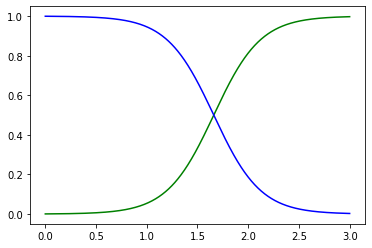

In [35]:
#꽃잎의 너비가 0~3센티미터인 꽃에 대해 모델이 추정 확률을 계산해보자
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b-', label='Not Iris virginica')

iris virginica의 꽃잎 너비는 1.4~2.5에 분포. 반면 다른 붓꽃은 일반적으로 조금 더 작다. 그래서 약간 중첩되는 부분이 있다. 이 부분에서는 분류가 확실하지 않다. 양쪽의 확률이 똑같이 0.5가 되는 1.6센치 부근에서 결정 경계가 만들어진다.

In [36]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

선형 결정 경계 그림을 보면 점선은 모델이 0.5 확률을 추정하는 지점으로, 이 경계는 대각선 방향으로 선형이다.

다른 선형 모델처럼 로지스틱 회귀로 l1, l2 페널티를 사용하여 규제할 수 있다. 사이킷런에서는 l2 페널티를 기본으로 한다.

###4.6.4 소프트맥스 회귀
로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있다. = 소프트맥스 회귀, 다항 로지스틱 회귀

샘플이 주어지면 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수를 계산하고, 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정한다. 샘플에 대해 각 클래스의 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 k에 속할 확률을 추정할 수 있다. 이 함수는 각 점수에 지수 함수를 적용한 후 정규화한다. 로짓 또는 로그-오즈. 추정 확률이 가장 높은 클래스를 선택.

훈련 방법을 보자. 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 하는 것이 목표. 크로스 엔트로피 비용 함수를 최소화 하자.

소프트맥스 회귀를 사용해 붓꽃을 세 개 클래스로 분류해보자.

In [37]:
X=iris['data'][:, (2,3)] #꽃잎 길이, 꽃잎 너비
y=iris['target']

softmax_reg=LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [39]:
#꽃잎 길이가 5, 너비가 2인 붓꽃 발견
softmax_reg.predict([[5,2]])

array([2])

In [40]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

그림을 보자. 결정 경계를 색으로 구분. 클래스 사이의 결정 경계가 모두 선형. 클래스에 대한 확률은 곡선으로 나타낸다.